In [1]:
import load as ld
import preprocessing as pp
from sklearn.model_selection import train_test_split
from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb
from training import save_importances, AveragingModels, LightGBMWrapper, XgbWrapper, GenericWrapper, OOFClassifier
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings(action='once')

/anaconda3/envs/kaggle/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
def get_tree_models():
    lgb_params = {}
    lgb_params['nthread'] = 3
    lgb_params['n_estimators'] = 10000
    lgb_params['learning_rate'] = 0.02
    lgb_params['colsample_bytree'] = 0.9497036
    lgb_params['subsample'] = 0.8715623
    lgb_params['max_depth'] = 8
    lgb_params["reg_alpha"] = 0.041545473
    lgb_params['reg_lambda'] = 0.0735294
    lgb_params['min_split_gain'] = 0.0222415
    lgb_params['min_child_weight'] = 39.3259775
    lgb_params['num_leaves'] = 34
    lgb_params['metric'] = 'auc'
    
    lgb_fit_params = {}
    lgb_fit_params['verbose_eval'] = 100
    lgb_fit_params['early_stopping_rounds'] = 200
    lgb_fit_params['valid_sets'] = {}
    lgb_fit_params['valid_names'] = ["train", "validation"]

    tree_models = []   

    lgbm = LightGBMWrapper(params = lgb_params, name = "lgbm")
    
    tree_models.append((lgbm, lgb_fit_params))
        
    return tree_models

In [3]:
def run_lgb(train_X, train_y, val_X, val_y, test_X, features = None, verbose = 50, early_stopping_rounds = 200):
    
    lgb_params = {}
    lgb_params['objective'] = "regression"
    lgb_params['metric'] = "rmse"
    lgb_params['num_leaves'] = 35
    lgb_params['min_child_weight'] = 50
    lgb_params['learning_rate'] = 0.025
    lgb_params['bagging_fraction'] = 0.75
    lgb_params['feature_fraction'] = 0.75
    lgb_params['bagging_frequency'] = 5
    lgb_params['bagging_seed'] = 2018
    lgb_params['n_estimators'] = 10000
    lgb_params['colsample_bytree'] = 0.75
    lgb_params['subsample'] = 0.75
    lgb_params['max_depth'] = 8
       
    if features == None:
        features = train_X.columns.tolist()
        
    #train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 2018)
    
    lgb_train = lgb.Dataset(data = train_X, label = train_y, feature_name = features)
    lgb_val = lgb.Dataset(data = val_X, label = val_y, feature_name = features)
    
    lgb_booster = lgb.train(params = lgb_params, train_set = lgb_train, valid_sets = [lgb_train, lgb_val], valid_names = ["train", "validation"], 
            verbose_eval = verbose, early_stopping_rounds = early_stopping_rounds)
    
    predictions = lgb_booster.predict(test_X, num_iteration = lgb_booster.best_iteration)
    
    return lgb_booster, predictions

In [4]:
def get_datasets(debug_size, silent, treat_duplicated = True):
    train, test = ld.get_processed_files(debug_size, silent)
    features = [f for f in train.columns if f not in ['target', 'card_id', 'index', 'first_active_month']]
    
    train_y = train['target']
    train_X = train.loc[:, features]

    ids = test['card_id']
    test_X = test.loc[:, features]
    
    return train_X, train_y, test_X, ids

In [5]:
debug_size = 0
silent = False
verbose = 100
early_stopping_rounds = 150

Full Model Run - Start!
Process train and test - Start!
Train df shape: (201917, 15)
Test df shape: (123623, 14)
Process train and test - Done in 1s



/anaconda3/envs/kaggle/lib/python3.6/site-packages/lightgbm/engine.py:113: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 150 rounds.
[100]	train's rmse: 3.83599	validation's rmse: 3.84933
[200]	train's rmse: 3.83454	validation's rmse: 3.85018
Early stopping, best iteration is:
[72]	train's rmse: 3.83695	validation's rmse: 3.84918

Training until validation scores don't improve for 150 rounds.
[100]	train's rmse: 3.84949	validation's rmse: 3.79555
[200]	train's rmse: 3.84819	validation's rmse: 3.79603
Early stopping, best iteration is:
[92]	train's rmse: 3.84973	validation's rmse: 3.79554

Training until validation scores don't improve for 150 rounds.
[100]	train's rmse: 3.83844	validation's rmse: 3.8411
[200]	train's rmse: 3.83705	validation's rmse: 3.84123
Early stopping, best iteration is:
[137]	train's rmse: 3.83784	validation's rmse: 3.84102

Training until validation scores don't improve for 150 rounds.
[100]	train's rmse: 3.84036	validation's rmse: 3.83188
[200]	train's rmse: 3.83918	validation's rmse: 3.83214
Early stopping, best iteration is:
[10

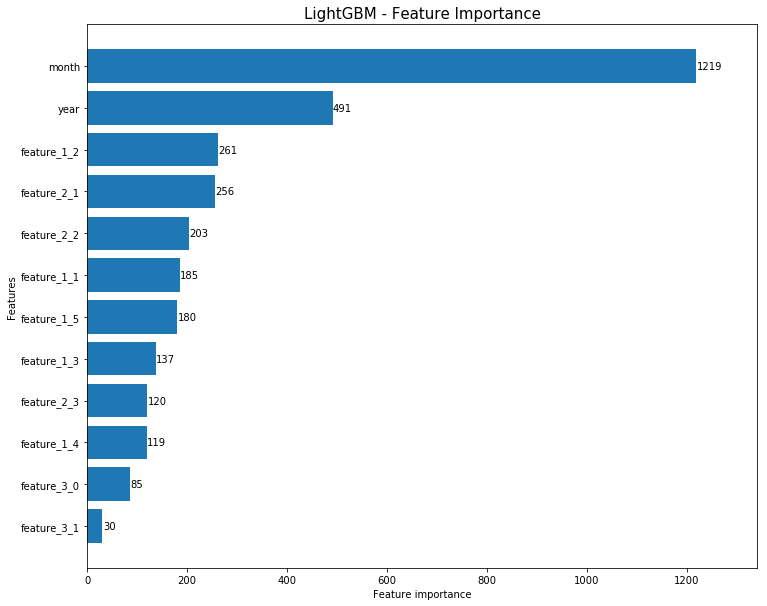

Full Model Run - Done in 12s



In [6]:
with pp.timer("Full Model Run"):
    train_X, train_y, test_X, ids = get_datasets(debug_size = debug_size, silent = silent)
    features = train_X.columns.tolist()
        
    pred_test = 0
    kf = model_selection.KFold(n_splits=5, random_state=2018, shuffle=True)
    for dev_index, val_index in kf.split(train_X):
        dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
    
        lgb_booster, predictions = run_lgb(dev_X, dev_y, val_X, val_y, test_X, features, verbose = verbose,  early_stopping_rounds = early_stopping_rounds)
        pred_test += predictions
        print("")
            
    pred_test /= 5.
        
    fig, ax = plt.subplots(figsize=(12,10))
    lgb.plot_importance(lgb_booster, max_num_features=50, height=0.8, ax=ax)
    ax.grid(False)
    plt.title("LightGBM - Feature Importance", fontsize=15)
    plt.show()
        
    sub_df = pd.DataFrame({"card_id": ids})
    sub_df["target"] = pred_test
    sub_df.to_csv("first_lgb.csv", index=False)

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, Ridge, SGDRegressor, LassoLars
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
import numpy as np

/anaconda3/envs/kaggle/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [8]:
model_lasso = Lasso(alpha = 0.000507)
model_ridge = Ridge()
model_ENet = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3, max_iter = 10000)
model_rforest = RandomForestRegressor()

In [9]:
print(np.sqrt((-cross_val_score(model_rforest, train_X, train_y, cv=3, scoring="neg_mean_squared_error"))))

[ 3.82214121  3.86294031  3.86954698]
